In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import librosa
import torch.nn as nn
import torchvision.models as models
from torch.optim import Adam
import torch.nn.functional as F
import math
import random
from torchvision import models

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
working_folder_path = ""
# Use GPU
if not torch.cuda.is_available():
    device = torch.device("cpu")
else:
    device = torch.device("cuda")


In [ ]:
class Mel_dataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_sample = self.inputs[idx]
        target_sample = self.targets[idx]
        return input_sample, target_sample

In [ ]:
def model_test(model, x, y):
    test_img = torch.randn(2, 1, x, y)
    out = model(test_img)
    return(out)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim=64, output_dim=32, hidden_size=1024):
        super(MLP, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            nn.ELU(),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ELU(),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, output_dim),
            nn.Sigmoid()
        )
    def forward(self, z):
        z = self.fc_layers(z)
        return z

In [ ]:
class VggEnc(nn.Module):
    def __init__(self, latent_size=64, hidden_size=1024):
        super(VggEnc, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        fc_in_dim = vgg16.classifier[0].in_features
        conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        conv1.weight.data = vgg16.features[0].weight.data.mean(dim=1, keepdim=True)
        vgg16.features[0] = conv1
        self.vgg16 = nn.Sequential(*list(vgg16.children())[:-1])
        self.fc1 = nn.Linear(fc_in_dim, hidden_size)
        self.fc2_mu = nn.Linear(hidden_size, hidden_size)
        self.fc3_mu = nn.Linear(hidden_size, latent_size)
        self.fc2_logvar = nn.Linear(hidden_size, hidden_size)
        self.fc3_logvar = nn.Linear(hidden_size, latent_size)
        self.batch_norm_fc1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.vgg16(x)
        x = x.reshape(x.size(0), -1)
        x = self.dropout(F.elu(self.batch_norm_fc1(self.fc1(x))))
        mu = self.fc2_mu(x)
        mu = self.fc3_mu(x)
        logvar = self.fc2_logvar(x)
        logvar = self.fc3_logvar(x)
        return mu, logvar

class VggDec(nn.Module):
    def __init__(self, latent_size=64, hidden_size=1024):
        super(VggDec, self).__init__()

        vgg16 = models.vgg16(pretrained=True)
        fc_out_dim = vgg16.classifier[0].in_features

        self.fc1 = nn.Linear(latent_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, fc_out_dim)
        self.batch_norm_fc1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.3)

        # Create a reversed VGG16 with transposed convolutional layers
        vgg16_layers = list(vgg16.features.children())
        vgg16_layers.reverse()

        self.transposed_layers = nn.ModuleList()
        prev_channels = 1

        for layer in vgg16_layers:
            if isinstance(layer, nn.Conv2d):
                transposed_layer = nn.ConvTranspose2d(layer.out_channels, layer.in_channels,
                                                      kernel_size=layer.kernel_size, stride=layer.stride,
                                                      padding=layer.padding, output_padding=layer.stride[0] - 1)
                prev_channels = layer.in_channels
                self.transposed_layers.append(transposed_layer)
            elif isinstance(layer, nn.ReLU):
                self.transposed_layers.append(nn.ReLU(inplace=True))
            elif isinstance(layer, nn.MaxPool2d):
                self.transposed_layers.append(nn.Upsample(scale_factor=layer.kernel_size, mode='bilinear', align_corners=False))
            else:
                self.transposed_layers.append(layer)
        # for layer in self.transposed_layers:
            # print(layer)
        # Update the last ConvTranspose2d layer's output channel to 1
        self.transposed_layers[-1] = nn.ConvTranspose2d(self.transposed_layers[-1].in_channels, 1,
                                                   kernel_size=self.transposed_layers[-1].kernel_size,
                                                   stride=self.transposed_layers[-1].stride,
                                                   padding=self.transposed_layers[-1].padding,
                                                   output_padding=self.transposed_layers[-1].output_padding)


        # self.transposed_vgg16 = nn.Sequential(*transposed_layers)

    def forward(self, x):
        # print(self.transposed_layers[-1].out_channels)
        x = self.dropout(F.elu(self.batch_norm_fc1(self.fc1(x))))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = x.reshape(x.size(0), 512, 7, 7)
        for layer in self.transposed_layers:
            # print(x.size())
            # print(layer)
            x = layer(x)
            
            
        return x

class VggVAE(nn.Module):
    def __init__(self, hidden_size=1024, latent_size=64):
        super(VggVAE, self).__init__()
        self.encoder = VggEnc(latent_size, hidden_size)
        self.decoder = VggDec(latent_size, hidden_size)
        self.mlp = MLP(input_dim=latent_size, output_dim=32, hidden_size=hidden_size)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        param = self.mlp(z)
        return x_recon, mu, logvar, param

vae_test = VggVAE(1024, 64)
x_recon, mu, logvar, param = model_test(vae_test, 224, 224)
print(x_recon.size(), param.size())
print(count_parameters(vae_test))

In [ ]:
class ResEnc(nn.Module):
    def __init__(self, hidden_size=1024, latent_size=64):
        super(ResEnc, self).__init__()

        super(ResEnc, self).__init__()
        res50 = models.resnet50(pretrained=True)
        fc_in_dim = res50.fc.in_features
        conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        conv1.weight.data = res50.conv1.weight.data.mean(dim=1, keepdim=True)
        res50.conv1 = conv1
        self.res50 = nn.Sequential(*list(res50.children())[:-1])
        self.fc1 = nn.Linear(fc_in_dim, hidden_size)
        self.fc2_mu = nn.Linear(hidden_size, hidden_size)
        self.fc3_mu = nn.Linear(hidden_size, latent_size)
        self.fc2_logvar = nn.Linear(hidden_size, hidden_size)
        self.fc3_logvar = nn.Linear(hidden_size, latent_size)
        self.batch_norm_fc1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.res50(x)
        x = x.reshape(x.size(0), -1)
        x = self.dropout(F.elu(self.batch_norm_fc1(self.fc1(x))))
        mu = self.fc2_mu(x)
        mu = self.fc3_mu(x)
        logvar = self.fc2_logvar(x)
        logvar = self.fc3_logvar(x)
        return mu, logvar

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=False, output_padding=0, kernel_size=4):
        super(ResidualBlock, self).__init__()
        self.upsample = upsample
        self.conv1 = nn.Conv2d(in_channels, out_channels // 4, kernel_size=1, stride=1)
        self.bn1 = nn.BatchNorm2d(out_channels // 4)
        self.conv2 = nn.Conv2d(out_channels // 4, out_channels // 4, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 4)
        self.conv3 = nn.Conv2d(out_channels // 4, out_channels, kernel_size=1, stride=1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        if self.upsample:
            self.shortcut = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=output_padding),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        identity = x

        if self.upsample:
            identity = self.shortcut(identity)
            x = F.interpolate(x, scale_factor=2, mode='nearest')

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x += identity
        x = F.relu(x)

        return x

class ResDec(nn.Module):
    def __init__(self, latent_size=64, hidden_size=1024, output_channels=1):
        super(ResDec, self).__init__()

        self.fc1 = nn.Linear(latent_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 512 * 7 * 7)
        self.batch_norm_fc1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.3)

        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(512, 512) for _ in range(2)],
            ResidualBlock(512, 256, upsample=True, output_padding=0, kernel_size=4),
            *[ResidualBlock(256, 256) for _ in range(5)],
            ResidualBlock(256, 128, upsample=True, output_padding=0, kernel_size=4),
            *[ResidualBlock(128, 128) for _ in range(3)],
            ResidualBlock(128, 64, upsample=True, output_padding=1, kernel_size=3),
            *[ResidualBlock(64, 64) for _ in range(2)],
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.ConvTranspose2d(32, output_channels, kernel_size=4, stride=2, padding=1, output_padding=0)
        )

    def forward(self, x):
        x = self.dropout(F.elu(self.batch_norm_fc1(self.fc1(x))))
        x = self.fc2(x)
        x = x.view(x.size(0), 512, 7, 7)
        x = self.residual_blocks(x)
        return x

class ResVAE(nn.Module):
    def __init__(self, hidden_size=1024, latent_size=64):
        super(ResVAE, self).__init__()
        self.encoder = ResEnc()
        self.decoder = ResDec()
        self.mlp = MLP(input_dim=latent_size, output_dim=32, hidden_size=hidden_size)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        param = self.mlp(z)
        return x_recon, mu, logvar, param

# Testing the ResVAE
vae_test = ResVAE(1024, 64)
x_recon, mu, logvar, param = model_test(vae_test, 224, 224)
print(x_recon.size(), param.size())
print(count_parameters(vae_test))


In [ ]:
class CNN1Enc(nn.Module):
    def __init__(self, in_channels=1, num_layers=5, conv_channels=64, kernel_size=3, stride=2, hidden_size=1024, latent_size=64):
        super(CNN1Enc, self).__init__()
        fc_in_dim = 21632 # x's dim2 * dim3 * dim4 at output of conv
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        for i in range(num_layers):
            dilation = 2 ** i
            padding = 3 * (dilation + 1)
            # dilation = 1
            # padding = 1 
            self.convs.append(nn.Conv2d(in_channels if i == 0 else conv_channels, conv_channels, kernel_size, stride, padding=padding, dilation=dilation))
            self.batch_norms.append(nn.BatchNorm2d(conv_channels))

        # fc in_size = flattend conv out shape, hand calculated or from model_test
        self.fc1 = nn.Linear(fc_in_dim, hidden_size)
        self.fc2_mu = nn.Linear(hidden_size, latent_size)
        self.fc2_logvar = nn.Linear(hidden_size, latent_size)
        self.batch_norm_fc1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        for conv, bn in zip(self.convs, self.batch_norms):
            x = F.elu(bn(conv(x)))
            # print(x.size())
        
        x = x.view(x.size(0), -1)
        x = self.dropout(F.elu(self.batch_norm_fc1(self.fc1(x))))
        mu = self.fc2_mu(x)
        logvar = self.fc2_logvar(x)
        return mu, logvar

class CNN1Dec(nn.Module):
    def __init__(self, out_channels=1, num_layers=5, conv_channels=64, kernel_size=3, stride=2, hidden_size=2048, latent_size=64):
        super(CNN1Dec, self).__init__()
        fc_out_dim = 21632
        self.fc1 = nn.Linear(latent_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, fc_out_dim)
        self.batch_norm_fc1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.3)
        
        self.convs_transpose = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        for i in reversed(range(num_layers)):
            dilation = 2 ** i
            padding = 3 * (dilation + 1)
            output_padding = 1
            # if i == 4: # from testing
            #     output_padding = (1, 1)
            if i == 1:
                output_padding = 0
            if i == 2:
                output_padding = 0
            if i == 3:
                output_padding = 1
            if i == 4:
                output_padding = 1
                
            self.convs_transpose.append(nn.ConvTranspose2d(conv_channels, out_channels if i == 0 else conv_channels, kernel_size, stride, padding=padding, output_padding=output_padding, dilation=dilation))
            self.batch_norms.append(nn.BatchNorm2d(out_channels if i == 0 else conv_channels))

    def forward(self, x):
        x = self.dropout(F.elu(self.batch_norm_fc1(self.fc1(x))))
        x = F.elu(self.fc2(x))
        x = x.reshape(x.size(0), 128, 13, 13)

        for conv_transpose, bn in zip(self.convs_transpose, self.batch_norms):
            x = F.elu(bn(conv_transpose(x)))
            # print(x.size())

        return x


class CNN1VAE(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_layers=5, conv_channels=128, kernel_size=7, stride=2, hidden_size=2048, latent_size=64):
        super(CNN1VAE, self).__init__()
        self.encoder = CNN1Enc(in_channels, num_layers, conv_channels, kernel_size, stride, hidden_size, latent_size)
        self.decoder = CNN1Dec(out_channels, num_layers, conv_channels, kernel_size, stride, hidden_size, latent_size)
        self.mlp = MLP(input_dim=latent_size, hidden_size=hidden_size)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        param = self.mlp(z)
        return x_recon, mu, logvar, param

in_channels = 1
out_channels = 1
vae_test = CNN1VAE(hidden_size=1024)
x_recon, mu, logvar, param = model_test(vae_test, 224, 224)
print(x_recon.size(), param.size())
print(count_parameters(vae_test))

In [ ]:
class CNN2Enc(nn.Module):
    def __init__(self, in_channels=1, num_layers=5, conv_channels=64, kernel_size=3, stride=2, hidden_size=1024, latent_size=64):
        super(CNN2Enc, self).__init__()
        fc_in_dim = 4608 # x's dim2 * dim3 * dim4 at output of conv
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        for i in range(num_layers):
            dilation = 1
            padding = 1
            self.convs.append(nn.Conv2d(in_channels if i == 0 else conv_channels, conv_channels, kernel_size, stride, padding=padding, dilation=dilation))
            self.batch_norms.append(nn.BatchNorm2d(conv_channels))

        # fc in_size = flattend conv out shape, hand calculated or from model_test
        self.fc1 = nn.Linear(fc_in_dim, hidden_size)
        self.fc2_mu = nn.Linear(hidden_size, latent_size)
        self.fc2_logvar = nn.Linear(hidden_size, latent_size)
        self.batch_norm_fc1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        for conv, bn in zip(self.convs, self.batch_norms):
            x = F.elu(bn(conv(x)))
            # print(x.size())
        
        x = x.view(x.size(0), -1)
        x = self.dropout(F.elu(self.batch_norm_fc1(self.fc1(x))))
        mu = self.fc2_mu(x)
        logvar = self.fc2_logvar(x)
        return mu, logvar

class CNN2Dec(nn.Module):
    def __init__(self, out_channels=1, num_layers=5, conv_channels=64, kernel_size=3, stride=2, hidden_size=1024, latent_size=64):
        super(CNN2Dec, self).__init__()
        fc_out_dim = 4608
        self.fc1 = nn.Linear(latent_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, fc_out_dim)
        self.batch_norm_fc1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.3)
        
        self.convs_transpose = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        for i in reversed(range(num_layers)):
            dilation = 1
            padding = 1
            output_padding = 0
            if i == 0:
                output_padding = 1
                
            self.convs_transpose.append(nn.ConvTranspose2d(conv_channels, out_channels if i == 0 else conv_channels, kernel_size, stride, padding=padding, output_padding=output_padding, dilation=dilation))
            self.batch_norms.append(nn.BatchNorm2d(out_channels if i == 0 else conv_channels))

    def forward(self, x):
        x = self.dropout(F.elu(self.batch_norm_fc1(self.fc1(x))))
        x = F.elu(self.fc2(x))
        x = x.reshape(x.size(0), 128, 6, 6)

        for conv_transpose, bn in zip(self.convs_transpose, self.batch_norms):
            x = F.elu(bn(conv_transpose(x)))
            # print(x.size())

        return x


class CNN2VAE(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_layers=5, conv_channels=128, kernel_size=5, stride=2, hidden_size=1024, latent_size=64):
        super(CNN2VAE, self).__init__()
        self.encoder = CNN2Enc(in_channels, num_layers, conv_channels, kernel_size, stride, hidden_size, latent_size)
        self.decoder = CNN2Dec(out_channels, num_layers, conv_channels, kernel_size, stride, hidden_size, latent_size)
        self.mlp = MLP(input_dim=latent_size, hidden_size=hidden_size)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        param = self.mlp(z)
        return x_recon, mu, logvar, param


vae_test = CNN2VAE()
x_recon, mu, logvar, param = model_test(vae_test, 224, 224)
print(x_recon.size(), param.size())
print(count_parameters(vae_test))

In [ ]:
# vae loss assume all prior distributions are normal
def vae_loss_kl(x, x_recon, mu, logvar, beta):
    # Reconstruction loss (MSE or Binary Cross Entropy)
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')  # Use F.binary_cross_entropy() if using a sigmoid activation in the decoder output

    # KL Divergence loss
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    loss = recon_loss + beta * kl_div
    return loss


def compute_mmd(z, true_samples):
    z = z.view(z.size(0), -1)
    true_samples = true_samples.view(true_samples.size(0), -1)
    z_kernel = torch.mm(z, z.t())
    true_samples_kernel = torch.mm(true_samples, true_samples.t())
    z_true_samples_kernel = torch.mm(z, true_samples.t())

    mmd = z_kernel.mean() + true_samples_kernel.mean() - 2 * z_true_samples_kernel.mean()
    return mmd

def vae_loss_mmd(x, x_recon, mu, logvar):
    # Reconstruction loss (MSE or Binary Cross Entropy)
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')  # Use F.binary_cross_entropy() if using a sigmoid activation in the decoder output

    # MMD loss
    std = torch.exp(0.5 * logvar)
    z = mu + torch.randn_like(std) * std
    true_samples = torch.randn_like(z)
    mmd_loss = compute_mmd(z, true_samples)

    # Total loss
    loss = recon_loss + mmd_loss
    return loss  

In [ ]:
from torch.utils.data import Subset

image_list = np.load(working_folder_path + "Res/image_list.npy")
param_list_32 = np.load(working_folder_path + "Res/param_list_32.npy")
# normalisation for resnet input
image_list = (image_list + 80)/80
# Instantiate your dataset
dataset = Mel_dataset(image_list, param_list_32)

# Load the train and test indices from the files
train_indices = np.load(working_folder_path+'Res/train_indices.npy')
test_indices = np.load(working_folder_path+'Res/test_indices.npy')


# Create the training and test subsets using the loaded indices
train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, test_indices)

In [ ]:
mean_signal_energy = torch.from_numpy(np.mean(abs(param_list_32), axis=0)).to(device)
class MSE_normalisaed(nn.Module):
    def __init__(self, mean_signal_energy):
        super(MSE_normalisaed, self).__init__()
        self.mean_signal_energy = mean_signal_energy
    def forward(self, output, target):
        loss = torch.mean(((output - target))**2 / self.mean_signal_energy)
        return loss

print(mean_signal_energy.size())

In [ ]:
# Hyperparameters for CNN1
in_channels = 1
out_channels = 1
num_layers = 5
conv_channels = 128
kernel_size = 7
stride = 2
hidden_size = 1024
latent_size = 64
num_epochs = 200

# Initialize the VAE model
# model = CNN1VAE(in_channels=in_channels, out_channels=out_channels, num_layers=num_layers, conv_channels=conv_channels, kernel_size=kernel_size, stride=stride, hidden_size=hidden_size, latent_size=latent_size).to(device)
# model = VggVAE(1024, 64).to(device)
# model = ResVAE().to(device)
# model = CNN2VAE().to(device)


## Training Section

In [ ]:
# Initialize the optimiser
learning_rate_vae_1 = 1e-4
learning_rate_mlp_1 = 0
optimizer = torch.optim.Adam([
    {'params': list(model.encoder.parameters()) + list(model.decoder.parameters()), 'lr': learning_rate_vae_1},
    {'params': model.mlp.parameters(), 'lr': learning_rate_mlp_1}
])

batch_size = 300
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

MSE_n = MSE_normalisaed(mean_signal_energy).to(device)
running_train_kls = []
running_train_mses = []
running_val_kls = []
running_val_mses = []

In [ ]:
break_point = 100
learning_rate_vae_2 = 0
learning_rate_mlp_2 = 1.5e-4
alpha = 0

In [ ]:
torch.cuda.empty_cache()
import time
t = time.time()

for epoch in range(num_epochs):

    model.train()
    running_train_kl = 0
    running_train_mse = 0
    beta = 0.5
    n_iter = 0
    for batch_idx, (mel_spectrogram, parameters) in enumerate(train_loader):
        mel_spectrogram = mel_spectrogram.type(torch.float32).to(device)
        parameters = parameters.type(torch.float32).to(device)

        optimizer.zero_grad()

        
        x_recon, mu, logvar, pred_param = model(mel_spectrogram)
        loss_kl = vae_loss_kl(x_recon, mel_spectrogram, mu, logvar, beta)
        loss_mse = MSE_n(pred_param, parameters)
        if epoch == break_point:
            optimizer = torch.optim.Adam([
                    {'params': list(model.encoder.parameters()) + list(model.decoder.parameters()), 'lr': learning_rate_vae_2},
                    {'params': model.mlp.parameters(), 'lr': learning_rate_mlp_2}])
            
        if epoch == 160:
            optimizer = torch.optim.Adam([
                    {'params': list(model.encoder.parameters()) + list(model.decoder.parameters()), 'lr': learning_rate_vae_2},
                    {'params': model.mlp.parameters(), 'lr': 0.5 * learning_rate_mlp_2}])
        
        if epoch < break_point:
            loss = loss_kl
        else:
            loss = loss_mse + alpha * loss_kl

        loss.backward()
        optimizer.step()
        running_train_kl += loss_kl.item()
        running_train_mse += loss_mse.item()
        n_iter += 1

    running_train_kl = running_train_kl/n_iter
    running_train_kls.append(running_train_kl)
    running_train_mse = running_train_mse/n_iter
    running_train_mses.append(running_train_mse)

    model.eval()
    running_val_kl = 0
    running_val_mse = 0
    n_iter = 0
    for batch_idx, (mel_spectrogram, parameters) in enumerate(val_loader):
        with torch.no_grad():
            mel_spectrogram = mel_spectrogram.type(torch.float32).to(device)
            parameters = parameters.type(torch.float32).to(device)
            x_recon, mu, logvar, pred_param = model(mel_spectrogram)
            loss_kl = vae_loss_kl(x_recon, mel_spectrogram, mu, logvar, beta)
            loss_mse = MSE_n(pred_param, parameters)
            if epoch < break_point:
                loss = loss_kl
            else:
                loss = loss_mse + alpha * loss_kl

            running_val_kl += loss_kl.item()
            running_val_mse += loss_mse.item()
            n_iter += 1

    running_val_kl = running_val_kl/n_iter
    running_val_kls.append(running_val_kl)
    running_val_mse = running_val_mse/n_iter
    running_val_mses.append(running_val_mse)

    print("Epoch [{}/{}], KLt: {:.4f}, KLv: {:.4f}, MSEt: {:.4f}, MSEv:{:.4f}".format(epoch+1, num_epochs, running_train_kl, running_val_kl, running_train_mse, running_val_mse))

elapsed = time.time() - t
print(elapsed)


In [ ]:
# save model weights for VAE
torch.save(model.state_dict(), working_folder_path + "Model_Param/VAE64CNN2—200.pth")

In [ ]:
# model = CNN1VAE(hidden_size=1024).to(device)
# model.load_state_dict(torch.load(working_folder_path + "Model_Param/VAE64CNN1—200sigmoid.pth", map_location=torch.device(device)))

# model = VggVAE().to(device)
# model.load_state_dict(torch.load(working_folder_path + "Model_Param/VAE64VGG—200sigmoid.pth", map_location=torch.device(device)))

# model = ResVAE().to(device)
# model.load_state_dict(torch.load(working_folder_path + "Model_Param/VAE64Res—200sigmoid.pth", map_location=torch.device(device)))

model = CNN2VAE().to(device)
# model_L1 = CNN2VAE().to(device)
# model_L2 = CNN2VAE().to(device)
model.load_state_dict(torch.load(working_folder_path + "Model_Param/VAE64CNN2—200signnmse.pth", map_location=torch.device(device)))
# model_L1.load_state_dict(torch.load(working_folder_path + "Model_Param/VAE64CNN2—200sigmoid.pth", map_location=torch.device(device)))
# model_L2.load_state_dict(torch.load(working_folder_path + "Model_Param/VAE64CNN2—200sigL2.pth", map_location=torch.device(device)))


print("ready")

ready


0.5087380409240723


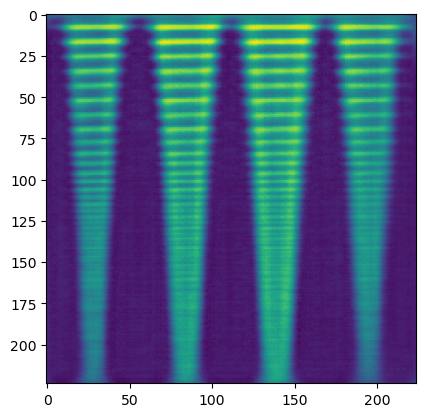

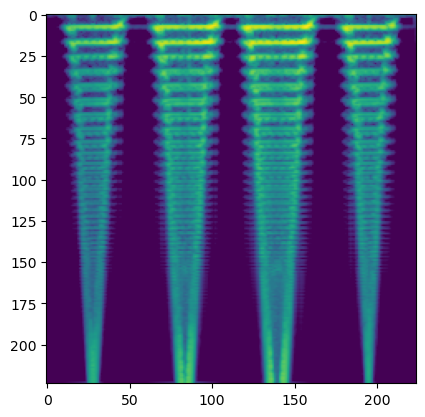

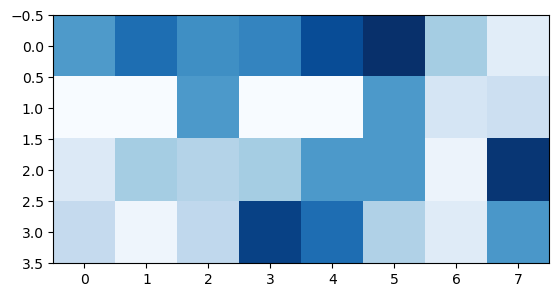

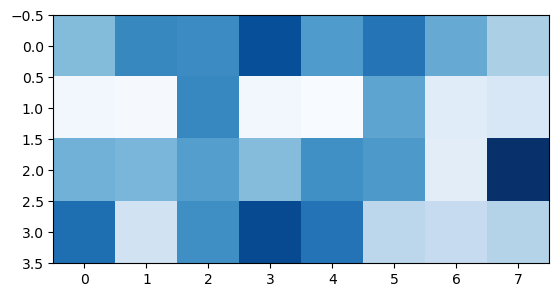

In [ ]:
# plot reconstruction
import time
t = time.time()
size_x, size_y = 224, 224
mel_img, label = val_set.__getitem__(700)
mel_img = mel_img.reshape(1, 1, size_x, size_y)
mel_img = torch.tensor(mel_img).type(torch.FloatTensor)

model.eval()
x_recon, mu, logvar, params_pred = model(mel_img)
x_recon = x_recon.cpu().detach().numpy()
prediction = x_recon.reshape(size_x, size_y)
mel_img = mel_img.cpu().detach().numpy().reshape(size_x, size_y)
params_pred = params_pred.cpu().detach().numpy()
param = params_pred.reshape(1, 32)
params_pred = params_pred.reshape(4, 8)
label = label.reshape(4, 8)
# print(x_recon)
plt.figure(1)
plt.imshow(prediction)
plt.savefig('figures/Prototype/val_700_recon_CNN2.eps')
plt.figure(2)
plt.imshow(mel_img)
plt.figure(3)
plt.imshow(label, cmap='Blues')
plt.figure(4)
plt.imshow(params_pred, cmap='Blues')
elapsed = time.time() - t
print(elapsed)

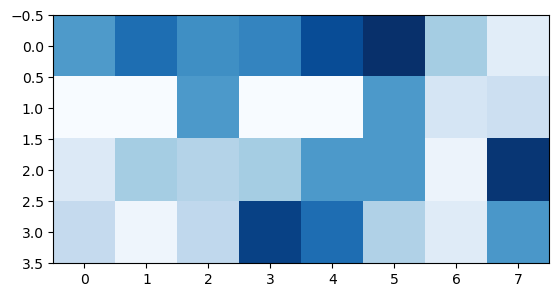

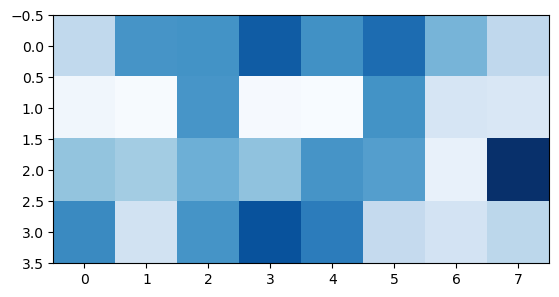

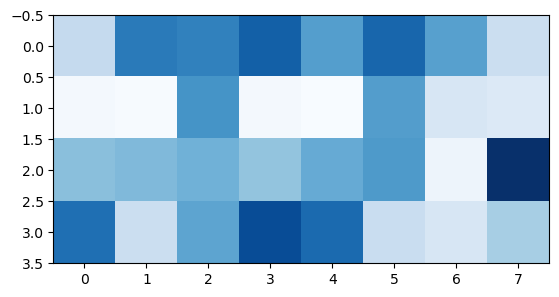

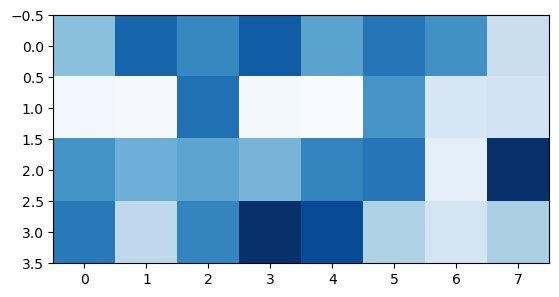

In [ ]:
# plot reconstruction
size_x, size_y = 224, 224
mel_img, label = val_set.__getitem__(700)
mel_img = mel_img.reshape(1, 1, size_x, size_y)
mel_img = torch.tensor(mel_img).type(torch.FloatTensor)
vals = np.zeros([4, 32])

model.eval()
x_recon, mu, logvar, params_pred = model(mel_img)
x_recon = x_recon.cpu().detach().numpy()
prediction = x_recon.reshape(size_x, size_y)
params_pred = params_pred.cpu().detach().numpy()
vals[0, :] = label
vals[1, :] = params_pred
params_pred = params_pred.reshape(4, 8)
label = label.reshape(4, 8)
plt.figure(1)
plt.imshow(label, cmap='Blues')
plt.figure(2)
plt.imshow(params_pred, cmap='Blues')

model_L1.eval()
x_recon, mu, logvar, params_pred = model_L1(mel_img)
x_recon = x_recon.cpu().detach().numpy()
prediction = x_recon.reshape(size_x, size_y)
params_pred = params_pred.cpu().detach().numpy()
vals[2, :] = params_pred
params_pred = params_pred.reshape(4, 8)
plt.figure(3)
plt.imshow(params_pred, cmap='Blues')

model_L2.eval()
x_recon, mu, logvar, params_pred = model_L2(mel_img)
x_recon = x_recon.cpu().detach().numpy()
prediction = x_recon.reshape(size_x, size_y)
params_pred = params_pred.cpu().detach().numpy()
vals[3, :] = params_pred
params_pred = params_pred.reshape(4, 8)
plt.figure(4)
plt.imshow(params_pred, cmap='Blues')
        

In [ ]:
# model.eval()
# running_val_param = 0
# running_val_recon = 0
# n_iter = 0
# batch_size = 160
# val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

# mean_img_energy = torch.from_numpy(np.mean(abs(image_list.reshape(image_list.shape[0], -1)), axis=0)).to(device)
# MSE_recon = MSE_normalisaed(mean_img_energy).to(device)
# MSE_param = MSE_normalisaed(mean_signal_energy).to(device)

# for batch_idx, (mel_spectrogram, parameters) in enumerate(val_loader):
#     with torch.no_grad():
#         mel_spectrogram = mel_spectrogram.type(torch.float32).to(device)
#         parameters = parameters.type(torch.float32).to(device)
#         x_recon, mu, logvar, pred_param = model(mel_spectrogram)
#         loss_recon = MSE_recon(x_recon.reshape(x_recon.size(0), -1), mel_spectrogram.reshape(x_recon.size(0), -1))
#         loss_param = MSE_param(pred_param, parameters)

#         running_val_recon += loss_recon.item()
#         running_val_param += loss_param.item()
#         n_iter += 1

# running_val_recon = running_val_recon/n_iter
# running_val_param = running_val_param/n_iter

# print(running_val_recon, running_val_param)

0.05952489757988134 0.18842878174094


In [ ]:
default_param = ['Phase1: Rate', 0.5, 'VCF1: ResModDepth', 0.5, 'Phase2: Phase', 0.0, 'Plate1: Decay', 0.5, 'VCA1: Offset', 0.0, 'VCF1: KeyFollow', 0.0, 'Delay1: Center Delay', 0.2, 'LFO1: DepthMod Src1', 0.0, 'CLK: Swing', 0.0, 'VCA1: PanModDepth', 0.5, 'Phase1: Depth', 1.0, 'OSC: PWModSrc', 0.0, 'ENV1: KeyFollow', 0.0, 'OPT: EnvrateSlop', 0.1, 'FX2: Module', 0.75, 'VCC: Glide', 0.0, 'OSC: DigitalType2', 0.0, 'OSC: DigitalType1', 0.0, 'Plate2: Damp', 0.8, 'ARP: Order', 0.0, 'Rtary1: Out', 0.5, 'VCC: PitchBend Down', 0.07692307692307693, 'OPT: V3Mod', 0.5, 'OSC: DigitalShape2', 0.0, 'OSC: DigitalShape3', 0.5, 'OSC: DigitalShape4', 0.0, 'ENV1: Decay', 0.5, 'Phase2: Center', 0.5, 'Plate1: Diffusion', 1.0, 'Rtary2: Fast', 0.85, 'OSC: Tune1ModDepth', 0.5, 'Rtary1: Mix', 1.0, 'VCF1: FeedbackModSrc', 0.0, 'main: Active #FX2', 0.0, 'main: Active #FX1', 0.0, 'VCF1: FilterFM', 0.5, 'Delay1: HP', 0.0, 'VCF1: ShapeModSrc', 0.7391304347826086, 'Rtary2: Mode', 0.0, 'Phase2: Rate', 0.5, 'LFO2: Restart', 0.3333333333333333, 'OSC: PWModDepth', 0.5, 'LFO1: FreqMod Dpt', 0.5, 'OSC: Drift', 0.175, 'OSC: Vibrato', 0.0, 'Rtary2: Out', 0.5, 'OSC: Model', 0.0, 'HPF: Model', 0.0, 'main: Output', 0.75, 'VCA1: Pan', 0.5, 'OSC: Sine2On', 0.0, 'VCF1: FreqModDepth', 0.5, 'OPT: OfflineAcc', 0.0, 'ENV2: Sustain', 0.0, 'ARP: Octaves', 0.0, 'LFO1: FreqMod Src1', 0.0, 'OSC: Tune1ModSrc', 0.6521739130434783, 'OSC: FM', 0.0, 'Rtary1: Fast', 0.85, 'Chrs2: Wet', 1.0, 'Chrs1: Rate', 0.5, 'Phase2: Depth', 1.0, 'Rtary2: RiseTime', 0.5, 'Chrs1: Wet', 1.0, 'Chrs2: Type', 0.0, 'LFO2: Waveform', 0.14285714285714285, 'Plate1: Wet', 0.4, 'LFO1: Delay', 0.0, 'OPT: V6Mod', 0.5, 'Delay2: Center Delay', 0.2, 'OSC: ShapeDepth', 0.5, 'ENV1: Velocity', 0.0, 'LFO2: DepthMod Dpt1', 0.0, 'Rtary2: Mix', 1.0, 'HPF: FreqModSrc', 0.0, 'ENV2: Decay', 0.5, 'OSC: Pulse2On', 0.0, 'MOD: MulSource2', 0.0, 'Delay1: Side Vol', 0.2, 'MOD: MulSource1', 0.0, 'VCC: Voices', 0.2857142857142857, 'OSC: TuneModMode', 0.0, 'PCore: LED Colour', 0.0, 'Phase1: Stereo', 0.5, 'VCF1: Feedback', 0.0, 'LFO2: FreqMod Src1', 0.0, 'LFO2: Sync', 0.038461538461538464, 'Delay2: Right Delay', 0.2, 'OSC: FmModSrc', 0.0, 'OSC: TuneModOsc1', 0.0, 'OSC: TuneModOsc2', 0.0, 'OSC: TuneModOsc3', 0.0, 'OSC: EcoWave2', 0.0, 'OSC: EcoWave1', 0.0, 'Plate2: Wet', 0.4, 'VCC: Transpose', 0.5, 'VCF1: SvfMode', 0.0, 'VCF1: LadderColor', 1.0, 'FX1: Module', 0.0, 'Delay1: LP', 1.0, 'Plate1: PreDelay', 0.0, 'MOD: RectifySource', 0.0, 'Rtary2: Drive', 0.0, 'ENV1: Release', 0.2, 'Delay2: Left Delay', 0.06666666666666667, 'Phase1: Center', 0.5, 'Phase2: Type', 0.0, 'ENV1: Curve', 0.0, 'Delay1: Center Vol', 0.0, 'OSC: PulseShape', 0.3333333333333333, 'VCA1: Mode', 0.0, 'ENV1: Attack', 0.01, 'ARP: Restart', 0.0, 'Phase2: Wet', 1.0, 'LFO2: Phase', 0.0, 'Rtary2: Stereo', 1.0, 'OPT: Accuracy', 0.0, 'VCF1: Model', 0.0, 'ENV2: Model', 0.5, 'Plate2: Size', 0.75, 'Delay1: Dry', 1.0, 'ENV2: Trigger', 0.0, 'Chrs2: Rate', 0.5, 'LFO1: DepthMod Dpt1', 1.0, 'VCF1: ShapeModDepth', 0.5, 'ENV1: Sustain', 1.0, 'OPT: V7Mod', 0.5, 'Delay2: Wow', 0.5, 'LFO1: Rate', 0.5, 'OSC: Saw2On', 1.0, 'CLK: Multiply', 0.3333333333333333, 'VCA1: Modulation', 0.0, 'Delay2: Center Vol', 0.0, 'VCC: Note Priority', 0.5, 'Plate1: Size', 0.75, 'Rtary1: Mode', 0.0, 'OPT: CutoffSlop', 0.1, 'ENV2: Release', 0.5, 'Phase1: Phase', 0.0, 'VCF1: ResModSrc', 0.0, 'MOD: Slew Rate', 0.5, 'Phase2: Sync', 0.0, 'VCF1: UhbieBandpass', 0.0, 'OSC: Sync2', 0.0, 'OSC: Sync3', 0.0, 'VCF1: FreqMod2Depth', 0.5, 'Plate1: Dry', 0.9, 'Plate2: PreDelay', 0.0, 'Phase1: Wet', 1.0, 'OSC: Volume3', 0.0, 'OSC: Volume2', 0.0, 'OSC: Volume1', 1.0, 'OPT: V5Mod', 0.5, 'VCF1: FreqMod2Src', 0.7391304347826086, 'OSC: OscMix', 1.0, 'OSC: Noise1On', 0.0, 'OSC: Tune2ModSrc', 0.0, 'OSC: NoiseVol', 0.0, 'VCF1: SlnKyRevision', 0.0, 'OSC: Triangle2On', 0.0, 'VCF1: Resonance', 0.0, 'LFO2: Rate', 0.5, 'VCC: MultiCore', 0.0, 'LFO1: Restart', 0.3333333333333333, 'OSC: ShapeModel', 0.5, 'VCC: GlideRange', 1.0, 'CLK: TimeBase', 0.6666666666666666, 'VCF1: FreqModSrc', 0.6521739130434783, 'Delay2: Side Vol', 0.2, 'LFO2: DepthMod Src1', 0.0, 'Rtary1: Controller', 0.0, 'Rtary2: Controller', 0.0, 'MOD: InvertSource', 0.0, 'VCC: TuningMode', 0.0, 'ENV2: KeyFollow', 0.0, 'HPF: Post-HPF Freq', 0.25, 'Rtary1: RiseTime', 0.5, 'Phase1: Type', 0.0, 'Plate1: Damp', 0.8, 'Chrs1: Depth', 0.5, 'Chrs1: Type', 0.0, 'Delay1: Left Delay', 0.06666666666666667, 'OPT: V1Mod', 0.5, 'VCC: GlideMode', 1.0, 'VCC: FineTuneCents', 0.5, 'OSC: DigitalAntiAlias', 0.0, 'VCC: Voice Stack', 0.0, 'ENV2: Curve', 0.0, 'VCF1: FeedbackModDepth', 0.5, 'Delay1: Wow', 0.5, 'ENV2: Attack', 0.01, 'HPF: KeyFollow', 0.0, 'LFO1: Waveform', 0.14285714285714285, 'Rtary1: Slow', 0.3, 'LFO1: Sync', 0.038461538461538464, 'VCC: PitchBend Up', 0.07692307692307693, 'Rtary1: Balance', 0.5, 'Plate2: Decay', 0.5, 'VCC: Mode', 0.25, 'VCF1: Frequency', 1.0, 'LFO2: Polarity', 0.0, 'VCA1: ModDepth', 0.5, 'OPT: TuneSlop', 0.35, 'Phase1: Feedback', 0.0, 'ENV2: Velocity', 0.0, 'VCC: Glide2', 0.53, 'VCF1: LadderMode', 0.0, 'OSC: SawShape', 0.0, 'VCF1: FmAmountModSrc', 0.0, 'OSC: NoiseVolModSrc', 0.0, 'MOD: QuantiseSource', 0.0, 'LFO1: Polarity', 0.0, 'OSC: ShapeSrc', 0.7391304347826086, 'Plate2: Diffusion', 1.0, 'OSC: FmModDepth', 0.5, 'HPF: Resonance', 0.0, 'OSC: Tune2ModDepth', 0.5, 'OPT: V4Mod', 0.5, 'ENV1: Trigger', 0.0, 'LFO2: FreqMod Dpt', 0.5, 'Scope1: Scale', 0.5, 'OSC: NoiseVolModDepth', 0.5, 'Delay1: Right Delay', 0.2, 'OSC: RingmodPulse', 0.0, 'ENV1: Model', 0.5, 'ENV1: Release On', 0.0, 'Rtary1: Drive', 0.0, 'MOD: AddSource2', 0.0, 'MOD: AddSource1', 0.0, 'ENV2: Quantise', 0.0, 'Scope1: Frequency', 0.2, 'VCA1: Volume', 0.5, 'HPF: Revision', 0.0, 'OSC: Tune1', 0.5, 'OSC: Tune3', 0.5, 'OSC: Tune2', 0.5, 'VCA1: PanModulation', 0.0, 'ENV1: Quantise', 0.0, 'HPF: FreqModDepth', 0.5, 'OSC: Saw1On', 1.0, 'OSC: PulseWidth', 0.5, 'Plate2: Dry', 0.9, 'OSC: ShapeModOsc1', 0.0, 'OSC: ShapeModOsc2', 0.0, 'OSC: ShapeModOsc3', 0.0, 'ARP: Direction', 0.2, 'Delay2: Feedback', 0.25, 'OSC: NoiseColor', 0.0, 'Phase2: Stereo', 0.5, 'OSC: Triangle1On', 0.0, 'Chrs2: Depth', 0.5, 'MOD: Quantise', 0.0, 'Delay1: Feedback', 0.25, 'VCF1: FmAmountModDepth', 0.5, 'Delay2: HP', 0.0, 'OSC: Shape1', 0.5, 'OSC: Shape3', 0.5, 'OSC: Shape2', 0.5, 'HPF: Frequency', 0.0, 'OPT: V2Mod', 0.5, 'MOD: LagSource', 0.0, 'ARP: OnOff', 0.0, 'Delay2: Dry', 1.0, 'Rtary2: Slow', 0.3, 'OSC: SuboscShape', 0.0, 'Rtary1: Stereo', 1.0, 'Phase2: Feedback', 0.0, 'ENV2: Release On', 0.0, 'OPT: V8Mod', 0.5, 'OPT: GlideSlop', 0.1, 'Rtary2: Balance', 0.5, 'OPT: PWSlop', 0.01, 'Delay2: LP', 1.0, 'LFO1: Phase', 0.0, 'VCF1: ShapeMix', 0.0, 'VCA1: VCA', 1.0, 'ARP: Multiply', 0.0, 'Phase1: Sync', 0.0, 'LFO2: Delay', 0.0, 'OSC: Pwm1On', 0.0, 'OSC: PWM2On', 1.0]
prediction_set = ['ENV1: Attack', 'ENV1: Decay', 'ENV1: Release', 'ENV1: Sustain', 'ENV2: Attack', 'ENV2: Decay', 'ENV2: Release', 'ENV2: Sustain', 'LFO1: Delay', 'LFO1: Phase', 'LFO1: Rate', 'LFO2: Delay', 'LFO2: Phase', 'LFO2: Rate', 'OSC: FM', 'OSC: NoiseVol', 'OSC: Shape1', 'OSC: Shape2', 'OSC: Shape3', 'OSC: Tune1', 'OSC: Tune2', 'OSC: Tune3', 'OSC: Vibrato', 'OSC: Volume2', 'OSC: Volume3', 'VCF1: Feedback', 'VCF1: FilterFM', 'VCF1: FreqMod2Depth', 'VCF1: FreqModDepth', 'VCF1: Frequency', 'VCF1: KeyFollow', 'VCF1: Resonance']
payload = ['Chrs1: Depth', 0.472432941198349, 
            'Chrs1: Rate', 0.48296841979026794, 
            'Chrs1: Wet', 0.5969037413597107, 
            'ENV1: Attack', 0.3, 
            'ENV1: Decay', 0.8, 
            'ENV1: KeyFollow', 0.38013574481010437, 
            'ENV1: Release', 0.6425888538360596, 
            'ENV1: Sustain', 0.5543093085289001, 
            'ENV1: Velocity', 0.4397014379501343, 
            'ENV2: Attack', 0.5665497183799744, 
            'ENV2: Decay', 0.5331721901893616, 
            'ENV2: KeyFollow', 0.1, 
            'ENV2: Release', 0.4226413667201996, 
            'ENV2: Sustain', 0.4782838523387909, 
            'ENV2: Velocity', 0.3993397653102875, 
            'HPF: Frequency', 0.9, 
            'HPF: Resonance', 0.3932980000972748, 
            'LFO1: Delay', 0.3947007358074188, 
            'LFO1: DepthMod Dpt1', 0.5678309798240662, 
            'LFO1: Phase', 0.39134639501571655, 
            'LFO1: Rate', 0.5151110887527466, 
            'LFO2: Delay', 0.37197408080101013, 
            'LFO2: DepthMod Dpt1', 0.40371087193489075, 
            'LFO2: FreqMod Dpt', 0.520001232624054, 
            'LFO2: Phase', 0.4088248014450073, 
            'LFO2: Rate', 0.619636058807373, 
            'MOD: Slew Rate', 0.4762002229690552, 
            'OSC: DigitalShape2', 0.39980486035346985, 
            'OSC: DigitalShape4', 0.4367016851902008, 
            'OSC: FM', 0.4979954659938812, 
            'OSC: NoiseVol', 0.3391054570674896, 
            'OSC: OscMix', 0.5038600564002991, 
            'OSC: PWModDepth', 0.4829753041267395, 
            'OSC: PulseWidth', 0.4852958619594574, 
            'OSC: Shape1', 0.4765433669090271, 
            'OSC: Shape2', 0.47739285230636597, 
            'OSC: Shape3', 0.48782220482826233, 
            'OSC: Tune1', 0.390672892332077, 
            'OSC: Tune1ModDepth', 0.49568963050842285, 
            'OSC: Tune2', 0.5477747321128845, 
            'OSC: Tune3', 0.5427697896957397, 
            'OSC: Vibrato', 0.3829651474952698, 
            'OSC: Volume1', 0.4198299050331116, 
            'OSC: Volume2', 0.6004632115364075, 
            'OSC: Volume3', 0.5273202657699585, 
            'Plate1: Diffusion', 0.58976149559021, 
            'Plate1: Wet', 0.9, 
            'Plate2: Damp', 0.5182753801345825, 
            'Plate2: Diffusion', 0.5872176885604858, 
            'Plate2: Size', 0.5505087375640869, 
            'Rtary1: Drive', 0.4155530035495758, 
            'Rtary1: Fast', 0.5376666784286499, 
            'VCA1: ModDepth', 0.49175918102264404, 
            'VCA1: PanModDepth', 0.517869234085083, 
            'VCA1: Volume', 0.4489431083202362, 
            'VCF1: Feedback', 0.3735322058200836, 
            'VCF1: FilterFM', 0.489663302898407, 
            'VCF1: FmAmountModDepth', 0.5022818446159363, 
            'VCF1: FreqMod2Depth', 0.5221697092056274, 
            'VCF1: FreqModDepth', 0.7664722204208374, 
            'VCF1: Frequency', 0.4715673625469208, 
            'VCF1: KeyFollow', 0.46107161045074463, 
            'VCF1: ResModDepth', 0.5031188726425171, 
            'VCF1: Resonance', 0.4081032872200012]

def payload_init(default_param, payload):
    for idx, item in enumerate(payload):
        if not idx % 2:
            key = payload[idx]
            position = default_param.index(key)
            payload[idx + 1] = default_param[position + 1]
            # print(payload[idx:idx+2])
    return payload

def construct_content(payload, prediction_set, vals):
    for idx, val in enumerate(vals):
        key = prediction_set[idx]
        position = payload.index(key)
        payload[position + 1] = val
    return payload

In [ ]:
label = vals[0, :]
payload  = payload_init(default_param, payload)
print(payload)
payload = construct_content(payload, prediction_set, label)
print(payload)

['Chrs1: Depth', 0.5, 'Chrs1: Rate', 0.5, 'Chrs1: Wet', 1.0, 'ENV1: Attack', 0.01, 'ENV1: Decay', 0.5, 'ENV1: KeyFollow', 0.0, 'ENV1: Release', 0.2, 'ENV1: Sustain', 1.0, 'ENV1: Velocity', 0.0, 'ENV2: Attack', 0.01, 'ENV2: Decay', 0.5, 'ENV2: KeyFollow', 0.0, 'ENV2: Release', 0.5, 'ENV2: Sustain', 0.0, 'ENV2: Velocity', 0.0, 'HPF: Frequency', 0.0, 'HPF: Resonance', 0.0, 'LFO1: Delay', 0.0, 'LFO1: DepthMod Dpt1', 1.0, 'LFO1: Phase', 0.0, 'LFO1: Rate', 0.5, 'LFO2: Delay', 0.0, 'LFO2: DepthMod Dpt1', 0.0, 'LFO2: FreqMod Dpt', 0.5, 'LFO2: Phase', 0.0, 'LFO2: Rate', 0.5, 'MOD: Slew Rate', 0.5, 'OSC: DigitalShape2', 0.0, 'OSC: DigitalShape4', 0.0, 'OSC: FM', 0.0, 'OSC: NoiseVol', 0.0, 'OSC: OscMix', 1.0, 'OSC: PWModDepth', 0.5, 'OSC: PulseWidth', 0.5, 'OSC: Shape1', 0.5, 'OSC: Shape2', 0.5, 'OSC: Shape3', 0.5, 'OSC: Tune1', 0.5, 'OSC: Tune1ModDepth', 0.5, 'OSC: Tune2', 0.5, 'OSC: Tune3', 0.5, 'OSC: Vibrato', 0.0, 'OSC: Volume1', 1.0, 'OSC: Volume2', 0.0, 'OSC: Volume3', 0.0, 'Plate1: Diffusi

In [ ]:
from pythonosc import udp_client

ip = '127.0.0.1'
out_port = 1233
client_2 = udp_client.SimpleUDPClient(ip, out_port)

In [ ]:
param = vals[2, :]
payload = construct_content(payload, prediction_set, param)
client_2.send_message('//params_nb', 64)
client_2.send_message('/params', payload)

In [ ]:
vals

array([[0.4982    , 0.6428    , 0.536     , 0.5691    , 0.7512    ,
        0.8462    , 0.3006    , 0.09      , 0.        , 0.        ,
        0.5       , 0.        , 0.        , 0.5       , 0.1448    ,
        0.1831    , 0.115     , 0.29875   , 0.25875   , 0.3       ,
        0.50116667, 0.5       , 0.0469    , 0.8258    , 0.2146    ,
        0.0385    , 0.22791667, 0.78783333, 0.64625   , 0.268     ,
        0.1014    , 0.5072    ],
       [0.24543284, 0.54836285, 0.55487508, 0.73969561, 0.56307453,
        0.68510777, 0.42720684, 0.24963474, 0.04252511, 0.02109584,
        0.5458433 , 0.02359399, 0.01455378, 0.55388618, 0.15827648,
        0.14510837, 0.3642804 , 0.32676876, 0.44685277, 0.37052497,
        0.54724616, 0.5103848 , 0.07981128, 0.88836026, 0.58665621,
        0.1837    , 0.552046  , 0.7751053 , 0.63060707, 0.23327287,
        0.17449322, 0.25993869],
       [0.2302234 , 0.63928878, 0.61458397, 0.72633088, 0.50985408,
        0.70781493, 0.50463897, 0.20520943, 0.0265